** Компьютерная лингвистика, домашнее задание №1.**  
Выполнено Красновым Станиславом и Климовым Александром.

In [1]:
import os
import re
from collections import Counter
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import DataFrame

Делаем наивную нормализацию из нашего семинара и удаляем первую строку на английском языке (кроме того, мы подготовили строку, которая удаляет == text == из выкачанных с Википедии статей (где содержатся названия разделов статей на Википедии, которые могли бы испортить нам биграммы и триграммы):

In [14]:
texts = []
start_path = 'udhr_txt'
for path, dirs, files in os.walk(start_path):
    for fname in files:
        with open(os.path.join(path, fname), encoding='utf-8') as f:
            raw_text = f.read()
            text = '\n'.join([line for line in raw_text.split('\n') if ':' not in line and line.strip()])
            text = re.sub('==.[\w\s]+.==', '', text)
            texts.append(re.sub('[\W\d]+', ' ', text.lower()))
                
print(len(texts), 'files')

452 files


Убираем текст в шапке: в каждом из 452 текстов в нашей выборке одинаковая есть одинаковая шапка (с вариациями городов), которую можно удалить таким образом.

In [15]:
texts2 = []
for i in texts:
    x = i.find('unicode') + 8
    texts2.append(i[x:-1])

print(len(texts2), 'files')

452 files


Создаём функцию, которая бы считала частоты слов, нграмм и биграмм и сразу же записывала их в отдельный файл.

In [16]:
def ngrams(txt_list):
    n=1
    for txt in txt_list:
        w = txt.split()
        words = Counter(w).most_common(300)
        x = 'Самые частотные слова:\n'
        for j in words:
            x += str(j)[1:-1] +'\n'
                
        bigrams = [tuple(w[i:i+2]) for i in range(len(w))][:-1]
        bigramsf = Counter(bigrams).most_common(300)
        x1 = '\nСамые частотные биграммы:\n'
        for j in bigramsf:
            x1 += str(j)[1:-1] +'\n'
            
        tgrams = [tuple(w[i:i+3]) for i in range(len(w))][:-1]
        tgramsf = Counter(tgrams).most_common(300)
        x2 = '\nСамые частотные триграммы:\n'
        for j in tgramsf:
            x2 += str(j)[1:-1] +'\n'
        
        with open('lang#'+str(n)+'.txt', 'w', encoding='utf-8') as file:
            file.write(x+x1+x2)
    
        n+=1
        
ngrams(texts2[0:7])

Здесь мы создаём матрицу схожести.

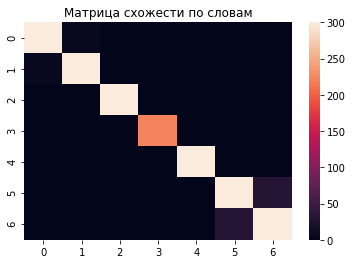

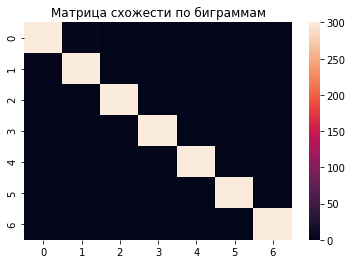

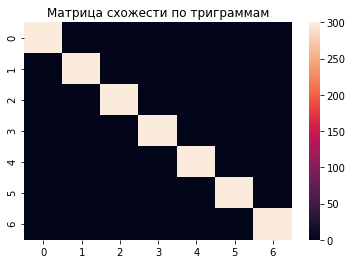

(array([[300,   7,   0,   0,   0,   0,   0],
        [  7, 300,   0,   1,   0,   0,   0],
        [  0,   0, 300,   0,   0,   0,   1],
        [  0,   1,   0, 222,   0,   0,   0],
        [  0,   0,   0,   0, 300,   0,   0],
        [  0,   0,   0,   0,   0, 300,  30],
        [  0,   0,   1,   0,   0,  30, 300]]),
 array([[300,   4,   0,   0,   1,   0,   0],
        [  4, 300,   0,   0,   0,   0,   0],
        [  0,   0, 300,   0,   0,   0,   0],
        [  0,   0,   0, 300,   0,   0,   0],
        [  1,   0,   0,   0, 300,   0,   0],
        [  0,   0,   0,   0,   0, 300,   0],
        [  0,   0,   0,   0,   0,   0, 300]]),
 array([[300,   0,   0,   0,   0,   0,   0],
        [  0, 300,   0,   0,   0,   0,   0],
        [  0,   0, 300,   0,   0,   0,   0],
        [  0,   0,   0, 300,   0,   0,   0],
        [  0,   0,   0,   0, 300,   0,   0],
        [  0,   0,   0,   0,   0, 300,   0],
        [  0,   0,   0,   0,   0,   0, 300]]))

In [29]:
def match(txt_list):
    
    #создаём и наполняем списки n-граммов
    word_list = []
    bigram_list = []
    tgram_list = []
    for txt in txt_list:
        w = txt.split()
        words = [i for i in w]
        wordsf = Counter(words).most_common(300)
        word_list.append(wordsf)
        bigrams = [tuple(w[i:i+2]) for i in range(len(w))][:-1]
        bigramsf = Counter(bigrams).most_common(300)
        bigram_list.append(bigramsf)
        tgrams = [tuple(w[i:i+3]) for i in range(len(w))][:-1]
        tgramsf = Counter(tgrams).most_common(300)
        tgram_list.append(tgramsf)
        
    #рассчитываем матрицу для каждого списка n-граммов
    for n in [word_list, bigram_list, tgram_list]:
        match_matrix=np.zeros(pow(len(n),2), dtype="int32")
        for i in range(len(n)):
            for j in range(len(n)):
                if i == j:
                    match_matrix[len(n)*i+j]=len(n[i])
                else:
                    match_matrix[len(n)*i+j]=len(set(n[i]) & set(n[j]))
        if n == word_list:
            word_matrix=match_matrix.reshape(len(n),len(n))
        elif n == bigram_list:
            bigram_matrix=match_matrix.reshape(len(n),len(n))
        else:
            tgram_matrix=match_matrix.reshape(len(n),len(n))
    
    #творим визуализацию
    sns.heatmap(DataFrame(word_matrix))
    plt.title("Матрица схожести по словам")
    a = plt.show()
    sns.heatmap(DataFrame(bigram_matrix))
    plt.title("Матрица схожести по биграммам")
    b = plt.show()
    sns.heatmap(DataFrame(tgram_matrix))
    plt.title("Матрица схожести по триграммам")
    c = plt.show()
    return word_matrix, bigram_matrix, tgram_matrix
    
match(texts2[0:7])

Мы работали с текстами Всеобщей декларации прав человека, и так как всего их было 452 в нашей выборке, мы постарались сделать наш код максимально универсальным, чтобы на вход можно было подавать любые тексты из этой выборки на любом языке, поэтому, собственно, у нас нет предпочтительных языков. <br>
Чтобы более подробно рассмотреть работу нашей матрицы, посмотрим на первые 7 языков в нашей выборке: креольский язык форру, креол Гвинеи-Биссау, мбунду, тетум, умбунду, бизиса и миджиса. Как видно, большинство языков неродственные, кроме креольских языков на основе португальского языка.